# Рекомендательная система тарифов мобильной связи на основе машинного обучения

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

Изначально импортируем необходимые библиотеки и загрузим даннные.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score 
from sklearn.dummy import DummyClassifier

In [3]:
df = pd.read_csv('datasets/users_behavior.csv')

Выведем краткую информацию о датасете.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Предобработка данных уже произведена.

Посмотрим также гистограммы признаков.

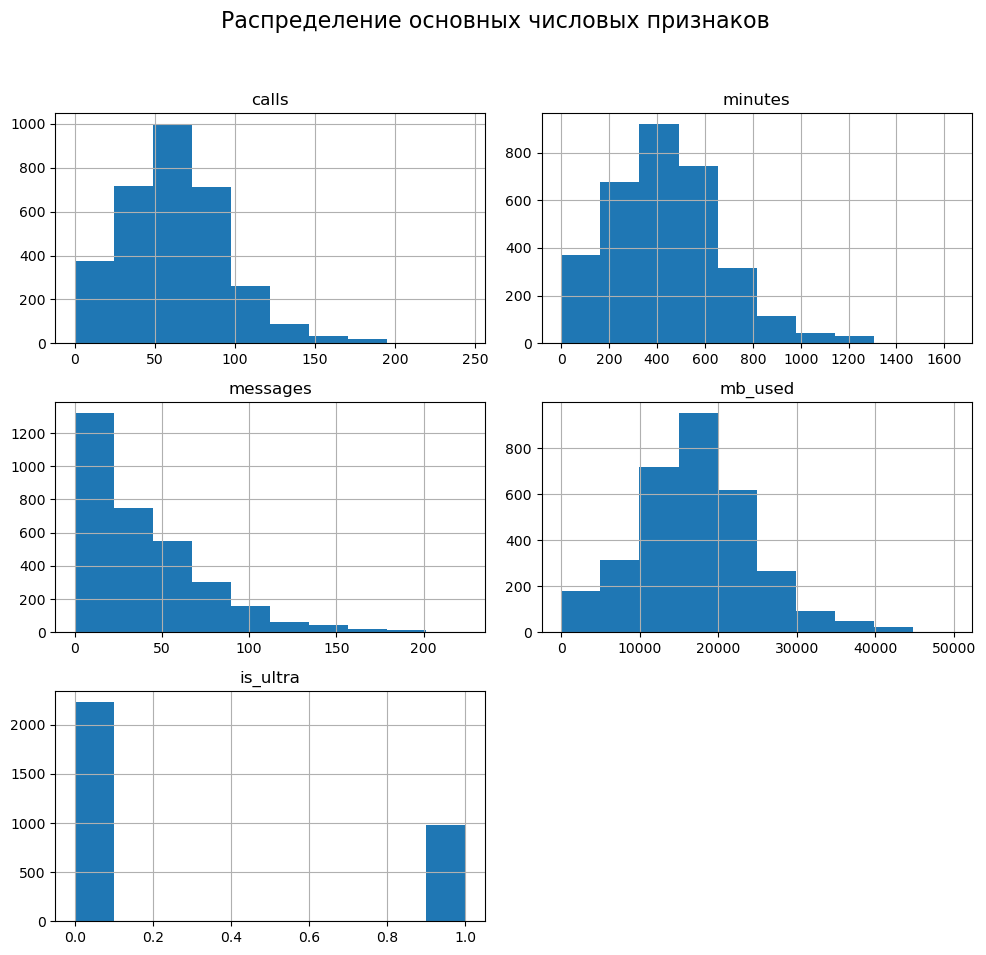

In [7]:
import matplotlib.pyplot as plt

df.hist(figsize=(10, 10))
plt.suptitle('Распределение основных числовых признаков', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Распределения признаков выглядят логично и без явных выбросов. Большинство пользователей имеет средние значения по звонкам, сообщениям и интернет-трафику, при этом распределения смещены вправо за счёт более активных клиентов. Целевой признак бинарный и представлен неравномерно, что важно учитывать при обучении модели.

## Подготовка данных

Изначально разобьем имеющиеся данные на 3 выборки с разным соотношением - тренировочную (60%), валидиционную (20%) и тестовую (20%).

In [8]:
df_train, df_valid = train_test_split(df, test_size=0.4, random_state=12345)

df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=12345)

Убедимся, выборки распределено верно.

In [9]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']
print(features_train.shape)
print(target_train.shape)

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']
print(features_valid.shape)
print(target_valid.shape)

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']
print(features_test.shape)
print(target_test.shape)

(1928, 4)
(1928,)
(643, 4)
(643,)
(643, 4)
(643,)


643 это 1/3 от 1928, все поделено правильно. Теперь можно поочередно работать с выборками.

## Исследуйте модели

Рассмотрим 3 вида моделей и проведем их по всем выборкам - тренировать по выборке `train`, фиксировать по выборке `valid` и окончательно проверять по выборке `test`. Будем оценивать модели дерева решений, случайного леса и логистической регрессии. 

В нашей задаче классификации будем оценивать метрику `accuracy`.

Начнем с дерева решений, будем подбирать для него гиперпараметр глубины дерева. Найдем глубину дерева с наилучшим показателем accuracy и сохраним такую модель как лучшую.

In [18]:
from sklearn.tree import DecisionTreeClassifier

best_model_tree = None
best_result_tree = 0
best_depth_tree = None

for depth in range(1, 6):
    model_tree = DecisionTreeClassifier(
        random_state=12345,
        max_depth=depth
    )
    model_tree.fit(features_train, target_train)
    result = model_tree.score(features_valid, target_valid)

    if result > best_result_tree:
        best_result_tree = result
        best_model_tree = model_tree
        best_depth_tree = depth

print(f'Лучший accuracy: {best_result_tree:.3f}')
print(f'max_depth: {best_depth_tree}')


Лучший accuracy: 0.785
max_depth: 3


Наилучший результат accuracy (0.78) был получен при максимальной глубине дерева равной 3.

Рассмотрим случайный лес. Найдем не только лучший параметр глубины, но и количества деревьев.

In [19]:
best_model_forest = None
best_result_forest = 0
best_est_forest = 0
best_depth_forest = 0
#for est in range(1, 51, 10):
for est in range(10, 101, 10):
    #for depth in range (1, 11):
    for depth in range(1, 21):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_train, target_train)
        #predictions_forest = model_forest.predict(features_valid)
        result_forest = model_forest.score(features_valid, target_valid) # accuracy_score(target_valid, predictions_forest) 
        if result_forest > best_result_forest:
            best_result_forest = result_forest
            best_model_forest = model_forest
            best_est_forest = est
            best_depth_forest = depth 

        
print(f'Лучший accuracy: {best_result_forest:.3f}')
print(f'n_estimators: {best_est_forest}')
print(f'max_depth: {best_depth_forest}')


Лучший accuracy: 0.809
n_estimators: 40
max_depth: 8


Случайный лес показал качество выше, чем одиночное дерево решений: на валидационной выборке удалось получить `accuracy` ≈ 0.809. Лучшие параметры в переборе — `n_estimators` = 40 и `max_depth` = 8, при дальнейшем увеличении глубины/числа деревьев заметного улучшения не наблюдается, а обучение становится дольше.

И последней воспроизведем модель логистической регрессии. Количество итераций поставим 1000 и также рассмотрим различные параметры `C`.

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

c_values = [0.001, 0.01, 0.1, 1, 10]

best_model_logic = None
best_result_logic = 0
best_c = None

for c in c_values:
    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(random_state=12345, C=c, solver='lbfgs', max_iter=2000)
    )
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)

    if result > best_result_logic:
        best_result_logic = result
        best_model_logic = model
        best_c = c
    print(f'C={c:<5} accuracy={result:.3f}')

print(f'Лучший accuracy: {best_result_logic:.3f}')
print(f'Лучший C: {best_c}')

C=0.001 accuracy=0.722
C=0.01  accuracy=0.754
C=0.1   accuracy=0.756
C=1     accuracy=0.756
C=10    accuracy=0.756
Лучший accuracy: 0.756
Лучший C: 0.1


Логистическая регрессия показала более низкое качество по сравнению с деревом решений и случайным лесом. Лучшее значение accuracy ≈ 0.756 было получено при C = 0.1, при этом модель лишь незначительно превышает минимально допустимый порог качества. В качестве финальной модели логистическая регрессия не выбирается, так как случайный лес демонстрирует более высокую точность.

## Проверка на тестовой выборке

Теперь проведем тестирование лучшей обученной модели на финальной выборке

In [23]:
#predictions_test_forest = best_model_forest.predict(features_test)
result_forest = best_model_forest.score(features_test, target_test)
print(f'Лучший accuracy на тестовой выборке: {result_forest:.3f}')

Лучший accuracy на тестовой выборке: 0.796


Лучшая модель — случайный лес — на тестовой выборке показала accuracy = 0.796, что немного ниже результата на валидационной выборке. При этом качество модели остаётся высоким и превышает 0.75, что говорит о её способности корректно обобщать данные.

## Проверка модели на адекватности

Также проверим модель на адекватность с помощью `Dummy Model`. Стратегию оставим `most_frequent`.

In [30]:
dummy_model = DummyClassifier(strategy='most_frequent')

dummy_model.fit(features_train, target_train)
#dummy_predict = dummy_model.predict(features_valid)
result = dummy_model.score(features_test, target_test)
print(f'Лучший результат Dummy Model: {result:.2f}')

Лучший результат Dummy Model: 0.68


Результат 0.68. Все  модели получили результат больше - это подтверждает, что обученная модель действительно извлекает полезные зависимости из данных и работает корректно. Таким образом, можно утверждать, что все в порядке и тестирование проведено.

## Итоговый вывод

Итак, подводя итог, можно сделать вывод о положительных результатах тестирования в рамках проекта. В процессе работы были выполнены следующие этапы::

1. Открыт и изучен исходный файл с данными: импортированы необходимые библиотеки, загружен датасет, а также проведено предварительное изучение данных с помощью методов `info()`, `describe()` и визуализации распределений признаков.

2. Исходные данные были разделены на три выборки: обучающую (60%), валидационную (20%) и тестовую (20%). Корректность разбиения была подтверждена сравнением размеров выборок.

3. Были исследованы три модели классификации: дерево решений, случайный лес и логистическая регрессия. Для каждой модели подбирались оптимальные гиперпараметры, при этом наилучшее значение метрики accuracy показала модель случайного леса. Все модели продемонстрировали accuracy выше 0.75 на валидационной выборке.

4. На тестовой выборке была проведена финальная проверка лучшей модели. Модель случайного леса показала accuracy = 0.796, что лишь незначительно ниже результата на валидационной выборке и превышает минимально допустимый порог качества..

5. На последнем этапе была выполнена проверка модели на адекватность с использованием DummyClassifier. Значение accuracy Dummy-модели оказалось ниже, чем у обученных моделей, что подтверждает корректность проведённого обучения и практическую ценность полученных результатов.
